In [1]:
# import libraries 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.patches as mpatches
import seaborn as sns
import pickle
from scipy.cluster import hierarchy
from sklearn.cluster import Birch
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, davies_bouldin_score

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering

In [2]:
my_colors = ['#88292F', '#697268', '#12355B', '#D7816A', '#e8da6f', '#c33b43', 
               '#9DBF9E', '#64a0e0', '#343934', '#280003','#cd5a61', '#913d27', 
               '#F46036', '#248232',  '#bea602', '#0a6682', '#646536', '#624763', '#2F1847', 
               '#FF7B9C', '#66A182', '#94849B', '#ACD8AA', '#F48498', '#B30089']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', my_colors)

In [3]:
pca_df = pd.read_csv('pca_df.csv')
df_wind_scaled = pd.read_csv('df_wind_scaled.csv')
df_subset = pd.read_csv('df_subset.csv')

In [4]:
# Plot dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# Hierarchical clustering

## Aglomerative

### Single Link

### Grid Search with cross validation

In [5]:
def combined_clustering_score(estimator, X, silhouette_weight=0.5, davies_bouldin_weight=0.5):
    labels = estimator.fit_predict(X)
    if len(np.unique(labels)) < 2:
        return np.nan  # Return NaN if only one or zero cluster labels are produced
    try:
        silhouette = silhouette_score(X, labels)
        davies_bouldin = davies_bouldin_score(X, labels)
        combined_score = silhouette_weight * silhouette + davies_bouldin_weight * davies_bouldin
        return combined_score
    except ValueError:
        return np.nan  # Return NaN if silhouette or Davies–Bouldin computation fails

Keeping number of defined clusters as none and test different distance threshold values:

In [6]:
# # Define the parameter grid
# param_grid = {
#     'distance_threshold': [0.01, 0.05, 0.1],
# }

# agg_clust = AgglomerativeClustering(linkage='single', n_clusters=None)

# # Initialize GridSearchCV
# grid_search = GridSearchCV(agg_clust, param_grid, scoring=silhouette_scorer, cv=2, verbose=2, n_jobs=-1)

# # Perform grid search
# grid_search.fit(pca_df)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[CV] END .............................distance_threshold=0.1; total time=  16.3s
[CV] END ............................distance_threshold=0.05; total time=  21.8s
[CV] END ............................distance_threshold=0.05; total time=  21.9s
[CV] END .............................distance_threshold=0.1; total time=  22.0s
[CV] END ............................distance_threshold=0.01; total time=  22.5s
[CV] END ............................distance_threshold=0.01; total time=  24.6s


GridSearchCV(cv=2,
             estimator=AgglomerativeClustering(linkage='single',
                                               n_clusters=None),
             n_jobs=-1, param_grid={'distance_threshold': [0.01, 0.05, 0.1]},
             scoring=<function silhouette_scorer at 0x7f57cbc8ede0>, verbose=2)

In [7]:
# # Get the best parameters
# best_params = grid_search.best_params_
# print("Best Parameters:", best_params)

# # Get the best silhouette score
# best_score = grid_search.best_score_
# print("Best Silhouette Score:", best_score)

Best Parameters: {'distance_threshold': 0.01}
Best Silhouette Score: 0.2223429397505562


keeping the distance threshold as none and testing different values for the numbers of clusters:

In [8]:
# # Define the parameter grid
# param_grid = {
#     'n_clusters': [2, 4, 6, 8, 10],
# }

# agg_clust = AgglomerativeClustering(linkage='single', distance_threshold=None)

# # Initialize GridSearchCV
# grid_search = GridSearchCV(agg_clust, param_grid, scoring=silhouette_scorer, cv=2, verbose=2, n_jobs=-1)

# # Perform grid search
# grid_search.fit(pca_df)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[CV] END .......................................n_clusters=4; total time=  27.9s
[CV] END .......................................n_clusters=4; total time=  28.0s
[CV] END .......................................n_clusters=8; total time=  28.2s
[CV] END .......................................n_clusters=6; total time=  28.4s
[CV] END .......................................n_clusters=2; total time=  28.0s
[CV] END .......................................n_clusters=6; total time=  28.9s
[CV] END .......................................n_clusters=8; total time=  29.3s
[CV] END .......................................n_clusters=2; total time=  28.4s
[CV] END ......................................n_clusters=10; total time=  12.7s
[CV] END ......................................n_clusters=10; total time=  12.8s


GridSearchCV(cv=2, estimator=AgglomerativeClustering(linkage='single'),
             n_jobs=-1, param_grid={'n_clusters': [2, 4, 6, 8, 10]},
             scoring=<function silhouette_scorer at 0x7f57cbc8ede0>, verbose=2)

In [9]:
# # Get the best parameters
# best_params = grid_search.best_params_
# print("Best Parameters:", best_params)

# # Get the best silhouette score
# best_score = grid_search.best_score_
# print("Best Silhouette Score:", best_score)

Best Parameters: {'n_clusters': 2}
Best Silhouette Score: 0.5096900002817247


Besides the silhouette score difference, the model will be fitted with the 0.01 distance threshold and then the dendrogram is going to be cut at the beggining to increase the silhouette score.

### Model with the parameters that offer the best silhouette score:

In [10]:
# # Fit Agglomerative Clustering model on the combined data
# model_single = AgglomerativeClustering(linkage= 'single',distance_threshold=0.01, n_clusters=None)
# model_single.fit(np.array(pca_df))

AgglomerativeClustering(distance_threshold=0.01, linkage='single',
                        n_clusters=None)

with the results from NbClust

In [6]:
# Fit Agglomerative Clustering model on the combined data
model_single = AgglomerativeClustering(linkage= 'single',distance_threshold=None, n_clusters=2)
model_single.fit(np.array(df_wind_scaled))

AgglomerativeClustering(linkage='single')

In [7]:
with open('results/hierarchical_opt/single_clustering.pickle', 'wb') as f:
    pickle.dump(model_single, f)

In [12]:
with open('results/hierarchical_opt/single_clustering.pickle', 'rb') as f:
    model_single = pickle.load(f)

In [8]:
# hierarchy.set_link_color_palette(my_colors)

# plt.figure(figsize=(12, 6))
# plt.title('Hierarchical Clustering Dendrogram')
# # Plot the dendrogram
# plot_dendrogram(model_single, truncate_mode='level', p = 5)
# plt.xlabel("Number of points in node (or index of point if no parenthesis).")
# plt.show()

without a distance threshold is not possible to plot a dendrogram

In [14]:
# # Cut dendrogram to obtain labels
# num_clusters = 2  # Adjust as needed

# # Convert the children_ attribute to a scipy hierarchical tree
# linkage_matrix = np.column_stack([model_single.children_, model_single.distances_,
#                                   np.ones_like(model_single.distances_)])
# # Cut the tree to obtain labels
# labels_cut = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# print(labels_cut)

[1 1 1 ... 1 1 1]


In [8]:
pca_df = pca_df.loc[:,:'PC2']

In [9]:
pca_df['cluster_label'] = model_single.labels_
pca_df['asset_id'] = df_subset['asset_id']

df_wind_scaled['cluster_label'] = model_single.labels_
df_wind_scaled['asset_id'] = df_subset['asset_id']

In [10]:
df_wind_scaled.to_csv('results/hierarchical_opt/csv_labels_cut_raw/single_link.csv', index = False)

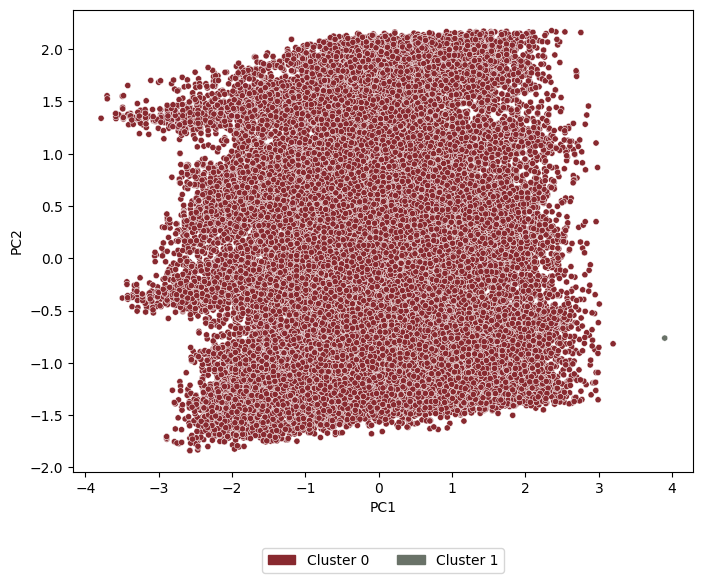

In [11]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
# plt.title('Single Link')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(model_single.labels_)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [12]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,0.738747,-0.734238,11,0
1,-0.199476,0.074563,11,0
2,-0.311128,0.662178,11,0
3,-0.800644,-0.655436,11,0
4,1.737677,1.319443,11,0


In [13]:
len(most_frequent_clusters.unique())

1

In [14]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,0.738747,-0.734238,0
1,12,-1.417553,-1.276716,0
2,13,1.219239,0.026342,0
3,14,-0.177437,0.586863,0
4,15,-0.862632,-1.080627,0
...,...,...,...,...
66,414,0.264004,1.670331,0
67,415,-0.666128,2.044155,0
68,510,-1.564608,-1.066597,0
69,511,-0.431002,-1.542170,0


In [15]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]


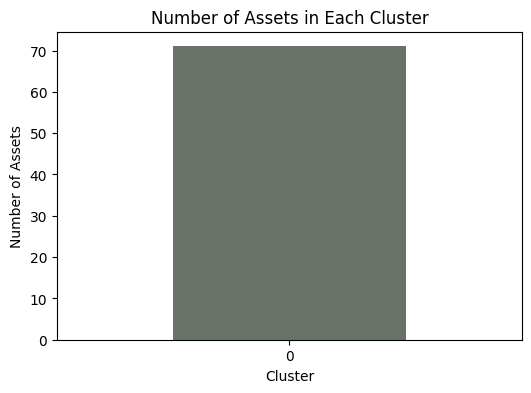

In [16]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [17]:
pca_df.to_csv('results/hierarchical_opt/labels_most_common/single_link.csv', index= False)

In [19]:
pca_df = pca_df.loc[:,:'PC2']
df_wind_scaled = df_wind_scaled.loc[:,:'2']

### Average Link

In [27]:
# # a shorter df needs to be made 'cause the kernel would die if trying to run with the normal one

# np.random.seed(10)

# asset = df_subset['asset_id'].unique()[0]

# length = len(df_subset[df_subset['asset_id'] == asset])

# subset_size = int(0.85 * length)  # Adjust the percentage as needed

# # Group the DataFrame by the asset identifier column(s)
# grouped = df_subset.groupby('asset_id')

# # Initialize an empty list to store the sampled data
# subset_data = []

# # Iterate over each group, sample subset_size rows from each group, and append to subset_data
# for _, group_df in grouped:
#     sampled_group = group_df.sample(n=subset_size, replace=False)
#     subset_data.append(sampled_group)

# # Concatenate the sampled data from all groups into a single DataFrame
# df_subset_short = pd.concat(subset_data)

In [28]:
# df_subset_short = df_subset_short.reset_index(drop = True)

In [29]:
# len(df_subset_short)

In [30]:
# df_subset_short

In [31]:
# X = df_subset_short.loc[:,'asset_id':]
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# pca = PCA(n_components=2)
# pca_short_result = pca.fit_transform(X_scaled)

# pca_df_short = pd.DataFrame(pca_short_result, columns=['PC1', 'PC2'])

Keeping number of defined clusters as none and test different distance threshold values:

In [32]:
# # Define the parameter grid
# param_grid = {
#     'distance_threshold': [0.01, 0.05],
# }

# avg_clust = AgglomerativeClustering(linkage='average', n_clusters=None)

# # Initialize GridSearchCV
# grid_search = GridSearchCV(avg_clust, param_grid, scoring=silhouette_scorer, cv=2, verbose=2, n_jobs=-1)

# # Perform grid search
# grid_search.fit(pca_df)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[CV] END ............................distance_threshold=0.05; total time= 1.4min
[CV] END ............................distance_threshold=0.05; total time= 1.5min
[CV] END ............................distance_threshold=0.01; total time= 1.5min
[CV] END ............................distance_threshold=0.01; total time= 1.5min


GridSearchCV(cv=2,
             estimator=AgglomerativeClustering(linkage='average',
                                               n_clusters=None),
             n_jobs=-1, param_grid={'distance_threshold': [0.01, 0.05]},
             scoring=<function silhouette_scorer at 0x7f57cbc8ede0>, verbose=2)

In [33]:
# # Get the best parameters
# best_params = grid_search.best_params_
# print("Best Parameters:", best_params)

# # Get the best silhouette score
# best_score = grid_search.best_score_
# print("Best Silhouette Score:", best_score)

Best Parameters: {'distance_threshold': 0.05}
Best Silhouette Score: 0.3712063902646236


keeping the distance threshold as none and testing different values for the numbers of clusters:

In [34]:
# # Define the parameter grid
# param_grid = {
#     'n_clusters': [2, 4, 6],
# }

# avg_clust = AgglomerativeClustering(linkage='average', distance_threshold=None)

# # Initialize GridSearchCV
# grid_search = GridSearchCV(avg_clust, param_grid, scoring=silhouette_scorer, cv=2, verbose=2, n_jobs=-1)

# # Perform grid search
# grid_search.fit(pca_df)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[CV] END .......................................n_clusters=4; total time= 2.0min
[CV] END .......................................n_clusters=6; total time= 2.1min
[CV] END .......................................n_clusters=4; total time= 2.1min
[CV] END .......................................n_clusters=2; total time= 2.1min
[CV] END .......................................n_clusters=6; total time= 2.2min
[CV] END .......................................n_clusters=2; total time= 2.2min


GridSearchCV(cv=2, estimator=AgglomerativeClustering(linkage='average'),
             n_jobs=-1, param_grid={'n_clusters': [2, 4, 6]},
             scoring=<function silhouette_scorer at 0x7f57cbc8ede0>, verbose=2)

In [35]:
# # Get the best parameters
# best_params = grid_search.best_params_
# print("Best Parameters:", best_params)

# # Get the best silhouette score
# best_score = grid_search.best_score_
# print("Best Silhouette Score:", best_score)

Best Parameters: {'n_clusters': 2}
Best Silhouette Score: 0.5149209823216134


Besides the silhouette score difference, the model will be fitted with the 0.05 distance threshold and then the dendrogram is going to be cut at the beggining to increase the silhouette score.

In [36]:
# model_average = AgglomerativeClustering(linkage='average', distance_threshold=0.05, n_clusters=None)
# model_average.fit(np.array(pca_df))

AgglomerativeClustering(distance_threshold=0.05, linkage='average',
                        n_clusters=None)

In [21]:
model_average = AgglomerativeClustering(linkage='average', distance_threshold=None, n_clusters=2)
model_average.fit(np.array(df_wind_scaled))

AgglomerativeClustering(linkage='average')

In [22]:
average_labels = model_average.labels_

In [23]:
len(np.unique(average_labels))

2

In [24]:
with open('results/hierarchical_opt/average_clustering.pickle', 'wb') as f:
    pickle.dump(model_average, f)

In [40]:
with open('results/hierarchical_opt/average_clustering.pickle', 'rb') as f:
    model_average = pickle.load(f)

In [36]:
# hierarchy.set_link_color_palette(my_colors)

# plt.figure(figsize=(12, 6))
# plt.title('Hierarchical Clustering Dendrogram')
# # Plot the dendrogram
# plot_dendrogram(model_average, truncate_mode='level', p = 5)
# plt.xlabel("Number of points in node (or index of point if no parenthesis).")
# plt.show()

In [42]:
# # Cut dendrogram to obtain labels
# num_clusters = 2  # Adjust as needed

# # Convert the children_ attribute to a scipy hierarchical tree
# linkage_matrix = np.column_stack([model_average.children_, model_average.distances_,
#                                   np.ones_like(model_average.distances_)])
# # Cut the tree to obtain labels
# labels_cut = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# print(labels_cut)

[1 1 1 ... 1 1 1]


In [25]:
# Assign the cluster labels to the original DataFrame
pca_df['cluster_label'] = average_labels
pca_df['asset_id'] = df_subset['asset_id']

df_wind_scaled['cluster_label'] = average_labels
df_wind_scaled['asset_id'] = df_subset['asset_id']

In [26]:
df_wind_scaled.to_csv('results/hierarchical_opt/csv_labels_cut_raw/average_link.csv', index=False)

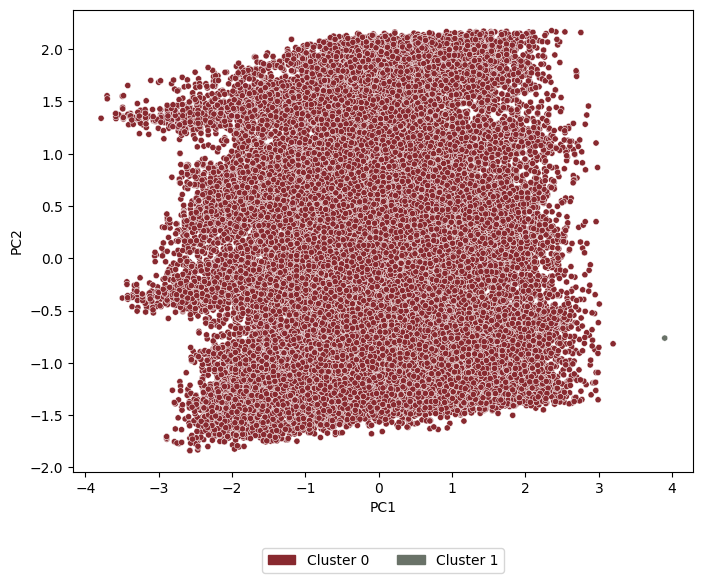

In [27]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
# plt.title('Average Link')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(average_labels)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [28]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,0.738747,-0.734238,11,0
1,-0.199476,0.074563,11,0
2,-0.311128,0.662178,11,0
3,-0.800644,-0.655436,11,0
4,1.737677,1.319443,11,0


In [29]:
len(pca_df['cluster_label'].unique())

1

In [30]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,0.738747,-0.734238,0
1,12,-1.417553,-1.276716,0
2,13,1.219239,0.026342,0
3,14,-0.177437,0.586863,0
4,15,-0.862632,-1.080627,0
...,...,...,...,...
66,414,0.264004,1.670331,0
67,415,-0.666128,2.044155,0
68,510,-1.564608,-1.066597,0
69,511,-0.431002,-1.542170,0


In [31]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]


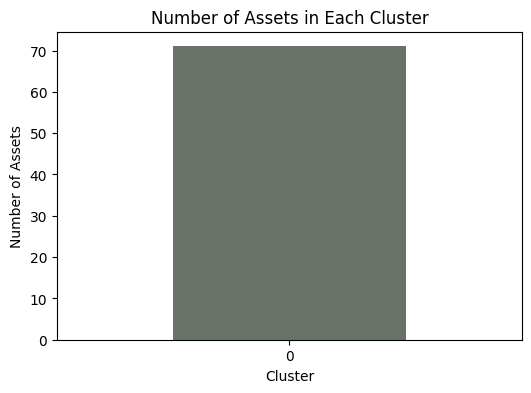

In [32]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [33]:
pca_df.to_csv('results/hierarchical_opt/labels_most_common/average_link.csv', index=False)

In [35]:
pca_df = pca_df.loc[:,:'PC2']

df_wind_scaled = df_wind_scaled.loc[:,:'2']

### Ward's method

In [56]:
# # Define the parameter grid
# param_grid = {
#     'distance_threshold': [0.01, 0.05, 0.1],
# }

# ward_clust = AgglomerativeClustering(linkage='ward', n_clusters=None)

# # Initialize GridSearchCV
# grid_search = GridSearchCV(ward_clust, param_grid, scoring=silhouette_scorer, cv=2, verbose=2, n_jobs=-1)

# # Perform grid search
# grid_search.fit(pca_df)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] END .............................distance_threshold=0.1; total time= 1.9min
[CV] END ............................distance_threshold=0.01; total time= 1.9min
[CV] END ............................distance_threshold=0.01; total time= 2.0min
[CV] END .............................distance_threshold=0.1; total time= 2.0min
[CV] END ............................distance_threshold=0.05; total time= 2.0min
[CV] END ............................distance_threshold=0.05; total time= 2.0min


GridSearchCV(cv=2, estimator=AgglomerativeClustering(n_clusters=None),
             n_jobs=-1, param_grid={'distance_threshold': [0.01, 0.05, 0.1]},
             scoring=<function silhouette_scorer at 0x7f57cbc8ede0>, verbose=2)

In [57]:
# # Get the best parameters
# best_params = grid_search.best_params_
# print("Best Parameters:", best_params)

# # Get the best silhouette score
# best_score = grid_search.best_score_
# print("Best Silhouette Score:", best_score)

Best Parameters: {'distance_threshold': 0.05}
Best Silhouette Score: 0.40832217991862274


keeping the distance threshold as none and testing different values for the numbers of clusters:

In [58]:
# # Define the parameter grid
# param_grid = {
#     'n_clusters': [2, 4, 6],
# }

# ward_clust = AgglomerativeClustering(linkage='ward', distance_threshold=None)

# # Initialize GridSearchCV
# grid_search = GridSearchCV(ward_clust, param_grid, scoring=silhouette_scorer, cv=2, verbose=2, n_jobs=-1)

# # Perform grid search
# grid_search.fit(pca_df)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] END .......................................n_clusters=4; total time= 1.9min
[CV] END .......................................n_clusters=2; total time= 2.0min
[CV] END .......................................n_clusters=6; total time= 2.0min
[CV] END .......................................n_clusters=6; total time= 2.0min
[CV] END .......................................n_clusters=2; total time= 2.0min
[CV] END .......................................n_clusters=4; total time= 2.0min


GridSearchCV(cv=2, estimator=AgglomerativeClustering(), n_jobs=-1,
             param_grid={'n_clusters': [2, 4, 6]},
             scoring=<function silhouette_scorer at 0x7f57cbc8ede0>, verbose=2)

In [59]:
# # Get the best parameters
# best_params = grid_search.best_params_
# print("Best Parameters:", best_params)

# # Get the best silhouette score
# best_score = grid_search.best_score_
# print("Best Silhouette Score:", best_score)

Best Parameters: {'n_clusters': 2}
Best Silhouette Score: 0.3356534202199616


In [6]:
model_ward = AgglomerativeClustering(linkage='ward', distance_threshold=None, n_clusters=3)
model_ward.fit(np.array(df_wind_scaled))

AgglomerativeClustering(n_clusters=3)

In [42]:
# hierarchy.set_link_color_palette(my_colors)

# plt.figure(figsize=(12, 6))
# plt.title('Hierarchical Clustering Dendrogram')
# # Plot the dendrogram
# plot_dendrogram(model_ward, truncate_mode='level', p=5)
# plt.xlabel("Number of points in node (or index of point if no parenthesis).")
# plt.show()

In [7]:
with open('results/hierarchical_opt/ward_clustering.pickle', 'wb') as f:
    pickle.dump(model_ward,f)

In [ ]:
with open('results/hierarchical_opt/ward_clustering.pickle', 'rb') as f:
    model_ward = pickle.load(f)

In [117]:
# # Cut dendrogram to obtain labels
# num_clusters = 5  # Adjust as needed

# # Convert the children_ attribute to a scipy hierarchical tree
# linkage_matrix = np.column_stack([model_ward.children_, model_ward.distances_,
#                                   np.ones_like(model_ward.distances_)])
# # Cut the tree to obtain labels
# labels_cut = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# print(labels_cut)

[2 5 5 ... 2 2 3]


In [8]:
pca_df = pca_df.loc[:,:'PC2']

In [9]:
# Assign the cluster labels to the original DataFrame
pca_df['cluster_label'] = model_ward.labels_
pca_df['asset_id'] = df_subset['asset_id']

df_wind_scaled['cluster_label'] = model_ward.labels_
df_wind_scaled['asset_id'] = df_subset['asset_id']

In [10]:
df_wind_scaled.to_csv('results/hierarchical_opt/csv_labels_cut_raw/ward_link.csv', index=False)

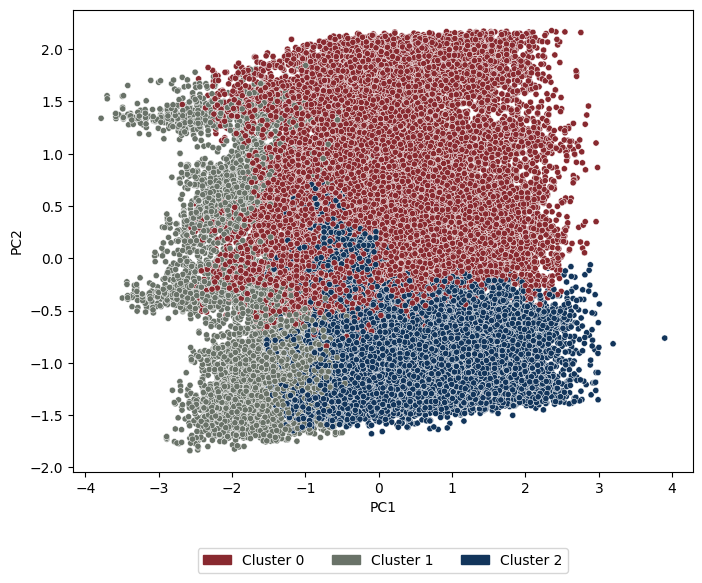

In [11]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
# plt.title("Ward's Link")
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(model_ward.labels_)],
            loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [12]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,0.738747,-0.734238,11,0
1,-0.199476,0.074563,11,0
2,-0.311128,0.662178,11,0
3,-0.800644,-0.655436,11,0
4,1.737677,1.319443,11,0


In [13]:
len(most_frequent_clusters.unique())

2

In [14]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,0.738747,-0.734238,0
1,12,-1.417553,-1.276716,0
2,13,1.219239,0.026342,0
3,14,-0.177437,0.586863,0
4,15,-0.862632,-1.080627,0
...,...,...,...,...
66,414,0.264004,1.670331,0
67,415,-0.666128,2.044155,0
68,510,-1.564608,-1.066597,2
69,511,-0.431002,-1.542170,2


In [15]:
pca_df.to_csv('results/hierarchical_opt/labels_most_common/ward_link.csv', index=False)

In [16]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]
Cluster 2: [32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 68, 69, 70]


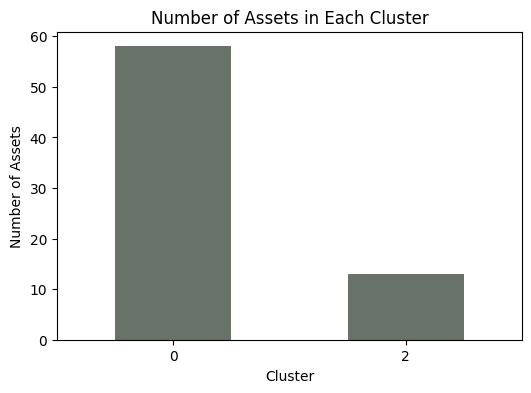

In [17]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [18]:
pca_df = pca_df[['PC1', 'PC2']]

df_wind_scaled = df_wind_scaled.loc[:,:'2']

### Centroid Linkage

In [19]:
# Perform hierarchical clustering
model_centroid = linkage(df_wind_scaled, 'centroid')

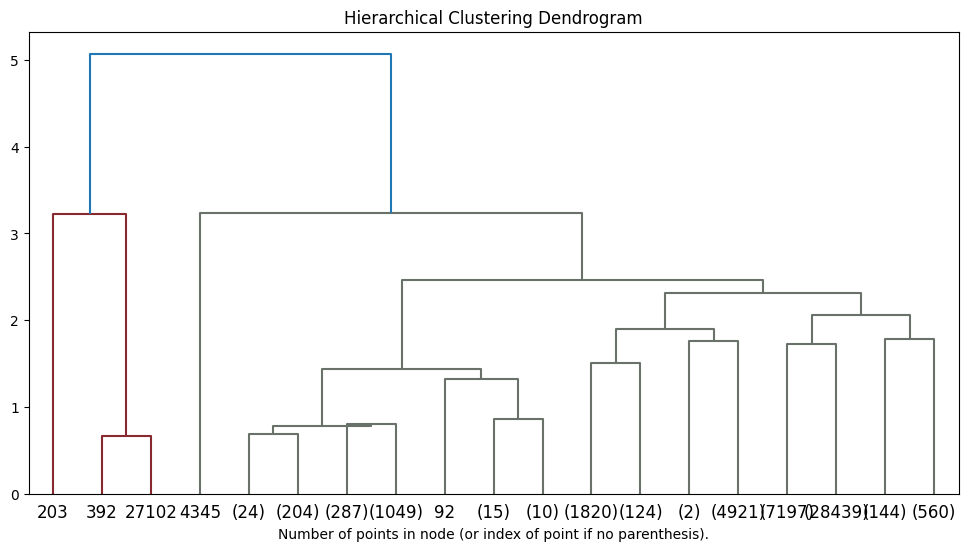

In [22]:
hierarchy.set_link_color_palette(my_colors)

plt.figure(figsize=(12, 6))
plt.title('Hierarchical Clustering Dendrogram')
# Plot the dendrogram
dendrogram(model_centroid, truncate_mode='level', p = 5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [21]:
with open('results/hierarchical_opt/centroid_clustering.pickle', 'wb') as f:
    pickle.dump(model_centroid,f)

In [6]:
with open('results/hierarchical_opt/centroid_clustering.pickle', 'rb') as f:
    model_centroid = pickle.load(f)

In [23]:
# Cut dendrogram to obtain labels
num_clusters = 2  # Adjust as needed

# Cut the tree to obtain labels
labels_cut = fcluster(model_centroid, num_clusters, criterion='maxclust')

print(labels_cut)

[2 2 2 ... 2 2 2]


In [24]:
pca_df = pca_df.loc[:,:'PC2']

In [25]:
# Assign the cluster labels to the original DataFrame
pca_df['cluster_label'] = labels_cut
pca_df['asset_id'] = df_subset['asset_id']

df_wind_scaled['cluster_label'] = labels_cut
df_wind_scaled['asset_id'] = df_subset['asset_id']

In [26]:
df_wind_scaled.to_csv('results/hierarchical_opt/csv_labels_cut_raw/centroid_link.csv', index=False)

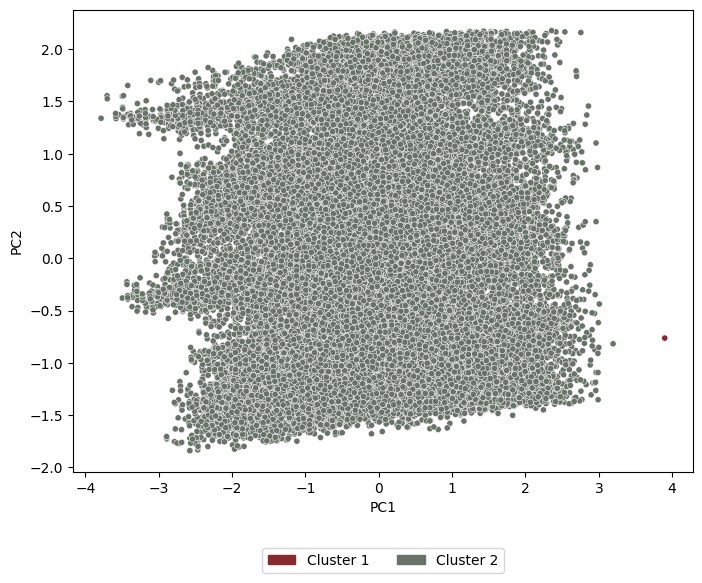

In [28]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
# plt.title("Centroid Link")
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(labels_cut)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [29]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,0.738747,-0.734238,11,2
1,-0.199476,0.074563,11,2
2,-0.311128,0.662178,11,2
3,-0.800644,-0.655436,11,2
4,1.737677,1.319443,11,2


In [30]:
len(most_frequent_clusters.unique())

1

In [31]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,0.738747,-0.734238,2
1,12,-1.417553,-1.276716,2
2,13,1.219239,0.026342,2
3,14,-0.177437,0.586863,2
4,15,-0.862632,-1.080627,2
...,...,...,...,...
66,414,0.264004,1.670331,2
67,415,-0.666128,2.044155,2
68,510,-1.564608,-1.066597,2
69,511,-0.431002,-1.542170,2


In [32]:
pca_df.to_csv('results/hierarchical_opt/labels_most_common/centroid_link.csv', index=False)

In [33]:
pca_df = pca_df.loc[:, :'PC2']

In [34]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 2: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]


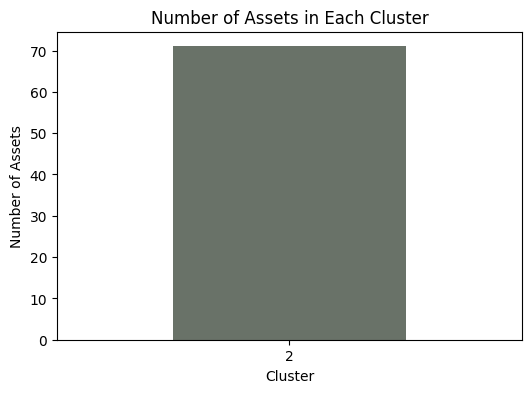

In [35]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

### BIRCH

In [47]:
df_wind_scaled = df_wind_scaled.loc[:,:'2']
pca_df = pca_df[['PC1', 'PC2']]

In [46]:
# Define the parameter grid
param_grid = {
    'threshold': [0.5, 1, 1.5, 2],
    'n_clusters': [None, 2, 3, 5, 10],
}

birch_clust = Birch()

# Initialize GridSearchCV
grid_search = GridSearchCV(birch_clust, param_grid, scoring=combined_clustering_score, cv=2, verbose=2, n_jobs=-1)

# Perform grid search
grid_search.fit(df_wind_scaled)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
[CV] END .......................n_clusters=None, threshold=2; total time=   1.4s
[CV] END .......................n_clusters=None, threshold=2; total time=   1.5s
[CV] END .....................n_clusters=None, threshold=0.5; total time=  19.1s
[CV] END .....................n_clusters=None, threshold=1.5; total time=  20.2s
[CV] END .....................n_clusters=None, threshold=1.5; total time=  20.5s
[CV] END .......................n_clusters=None, threshold=1; total time=  20.6s
[CV] END .......................n_clusters=None, threshold=1; total time=  20.7s
[CV] END .....................n_clusters=None, threshold=0.5; total time=  20.7s


/home/sara/.local/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (2). Decrease the threshold.
  warnings.warn(
/home/sara/.local/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (2). Decrease the threshold.
  warnings.warn(
/home/sara/.local/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (2). Decrease the threshold.
  warnings.warn(


[CV] END ..........................n_clusters=2, threshold=2; total time=   1.7s


/home/sara/.local/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (2). Decrease the threshold.
  warnings.warn(


[CV] END ..........................n_clusters=2, threshold=2; total time=   1.8s
[CV] END ........................n_clusters=2, threshold=0.5; total time=  22.5s
[CV] END ........................n_clusters=2, threshold=0.5; total time=  22.5s
[CV] END ..........................n_clusters=2, threshold=1; total time=  17.9s


/home/sara/.local/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (2) by BIRCH is less than (3). Decrease the threshold.
  warnings.warn(


[CV] END ..........................n_clusters=2, threshold=1; total time=  17.4s


/home/sara/.local/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (2) by BIRCH is less than (3). Decrease the threshold.
  warnings.warn(
/home/sara/.local/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (2) by BIRCH is less than (3). Decrease the threshold.
  warnings.warn(


[CV] END ........................n_clusters=2, threshold=1.5; total time=  17.9s


/home/sara/.local/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (2) by BIRCH is less than (3). Decrease the threshold.
  warnings.warn(
/home/sara/.local/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (3). Decrease the threshold.
  warnings.warn(


[CV] END ........................n_clusters=2, threshold=1.5; total time=  18.8s


/home/sara/.local/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (3). Decrease the threshold.
  warnings.warn(
/home/sara/.local/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (3). Decrease the threshold.
  warnings.warn(


[CV] END ..........................n_clusters=3, threshold=2; total time=   1.4s


/home/sara/.local/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (3). Decrease the threshold.
  warnings.warn(


[CV] END ..........................n_clusters=3, threshold=2; total time=   1.2s
[CV] END ........................n_clusters=3, threshold=0.5; total time=  18.6s
[CV] END ..........................n_clusters=3, threshold=1; total time=  18.0s
[CV] END ..........................n_clusters=3, threshold=1; total time=  18.3s
[CV] END ........................n_clusters=3, threshold=0.5; total time=  19.6s


/home/sara/.local/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (2) by BIRCH is less than (5). Decrease the threshold.
  warnings.warn(
/home/sara/.local/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (2) by BIRCH is less than (5). Decrease the threshold.
  warnings.warn(
/home/sara/.local/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (2) by BIRCH is less than (5). Decrease the threshold.
  warnings.warn(
/home/sara/.local/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (2) by BIRCH is less than (5). Decrease the threshold.
  warnings.warn(


[CV] END ........................n_clusters=3, threshold=1.5; total time=  17.6s
[CV] END ........................n_clusters=3, threshold=1.5; total time=  18.4s


/home/sara/.local/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (5). Decrease the threshold.
  warnings.warn(
/home/sara/.local/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (5). Decrease the threshold.
  warnings.warn(
/home/sara/.local/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (5). Decrease the threshold.
  warnings.warn(
/home/sara/.local/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (5). Decrease the threshold.
  warnings.warn(


[CV] END ..........................n_clusters=5, threshold=2; total time=   1.2s
[CV] END ..........................n_clusters=5, threshold=2; total time=   1.4s
[CV] END ........................n_clusters=5, threshold=0.5; total time=  18.0s
[CV] END ........................n_clusters=5, threshold=0.5; total time=  18.9s
[CV] END ..........................n_clusters=5, threshold=1; total time=  18.3s
[CV] END ........................n_clusters=5, threshold=1.5; total time=  17.2s


/home/sara/.local/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (2) by BIRCH is less than (10). Decrease the threshold.
  warnings.warn(


[CV] END ..........................n_clusters=5, threshold=1; total time=  17.8s


/home/sara/.local/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (2) by BIRCH is less than (10). Decrease the threshold.
  warnings.warn(
/home/sara/.local/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (10). Decrease the threshold.
  warnings.warn(


[CV] END ........................n_clusters=5, threshold=1.5; total time=  18.1s


/home/sara/.local/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (2) by BIRCH is less than (10). Decrease the threshold.
  warnings.warn(
/home/sara/.local/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (2) by BIRCH is less than (10). Decrease the threshold.
  warnings.warn(
/home/sara/.local/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (10). Decrease the threshold.
  warnings.warn(


[CV] END .........................n_clusters=10, threshold=2; total time=   1.2s


/home/sara/.local/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (10). Decrease the threshold.
  warnings.warn(
/home/sara/.local/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (1) by BIRCH is less than (10). Decrease the threshold.
  warnings.warn(


[CV] END .........................n_clusters=10, threshold=2; total time=   1.8s
[CV] END .......................n_clusters=10, threshold=0.5; total time=  15.5s
[CV] END .........................n_clusters=10, threshold=1; total time=  14.0s
[CV] END .........................n_clusters=10, threshold=1; total time=  14.4s
[CV] END .......................n_clusters=10, threshold=0.5; total time=  16.8s
[CV] END .......................n_clusters=10, threshold=1.5; total time=  14.3s
[CV] END .......................n_clusters=10, threshold=1.5; total time=  14.2s


/home/sara/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [0.65585242 0.67443728 0.79151279        nan 0.88607059 0.59908116
 0.79151279        nan 0.80926572 0.68530463 0.79151279        nan
 0.72252993 0.71561883 0.79151279        nan 0.63988842 0.65090659
 0.79151279        nan]
  warnings.warn(


GridSearchCV(cv=2, estimator=Birch(), n_jobs=-1,
             param_grid={'n_clusters': [None, 2, 3, 5, 10],
                         'threshold': [0.5, 1, 1.5, 2]},
             scoring=<function combined_clustering_score at 0x7f418b9b3100>,
             verbose=2)

In [48]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best silhouette score
best_score = grid_search.best_score_
print("Best Silhouette Score:", best_score)

Best Parameters: {'n_clusters': 2, 'threshold': 0.5}
Best Silhouette Score: 0.8860705941208862


In [49]:
brc = Birch(n_clusters=2, threshold=0.5)
brc.fit(df_wind_scaled)
labels = brc.predict(df_wind_scaled)
labels

array([1, 0, 0, ..., 1, 0, 0])

In [50]:
with open('results/hierarchical_opt/birch.pickle', 'wb') as f:
    pickle.dump(brc, f)

In [51]:
pca_df['cluster_label'] = labels 
pca_df['asset_id'] = df_subset['asset_id']

df_wind_scaled['cluster_label'] = labels 
df_wind_scaled['asset_id'] = df_subset['asset_id']
df_wind_scaled.head()

,0,1,2,cluster_label,asset_id
0,0.797093,-0.426693,0.517135,1,11
1,0.035012,-0.925224,-1.204735,0,11
2,-0.653319,-0.133978,-0.487289,0,11
3,0.600427,0.440781,-0.774268,0,11
4,-1.233485,-0.673672,1.952027,1,11


In [52]:
df_wind_scaled.to_csv('results/hierarchical_opt/csv_labels_cut_raw/birch.csv', index = False)

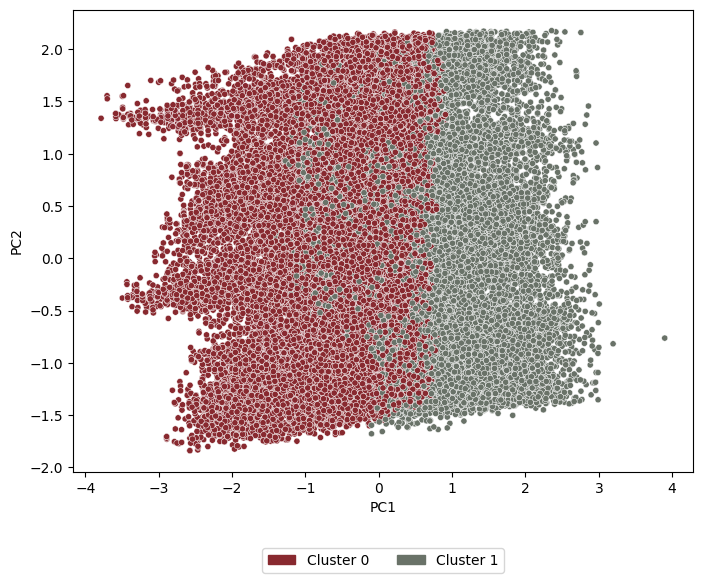

In [53]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
# plt.title("BIRCH")
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(labels)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [54]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,0.738747,-0.734238,11,0
1,-0.199476,0.074563,11,0
2,-0.311128,0.662178,11,0
3,-0.800644,-0.655436,11,0
4,1.737677,1.319443,11,0


In [55]:
len(most_frequent_clusters.unique())

2

In [56]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,0.738747,-0.734238,0
1,12,-1.417553,-1.276716,0
2,13,1.219239,0.026342,0
3,14,-0.177437,0.586863,0
4,15,-0.862632,-1.080627,0
...,...,...,...,...
66,414,0.264004,1.670331,0
67,415,-0.666128,2.044155,0
68,510,-1.564608,-1.066597,0
69,511,-0.431002,-1.542170,0


In [57]:
assets_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Print assets in each cluster
for cluster, assets in assets_clusters.groupby(assets_clusters):
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [11, 12, 13, 14, 15, 16, 17, 18, 19, 22, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 58, 59, 110, 111, 112, 113, 114, 115, 116, 117, 210, 310, 311, 312, 313, 314, 315, 316, 317, 410, 411, 412, 413, 414, 415, 510, 511, 512]
Cluster 1: [21, 23, 26, 29, 57]


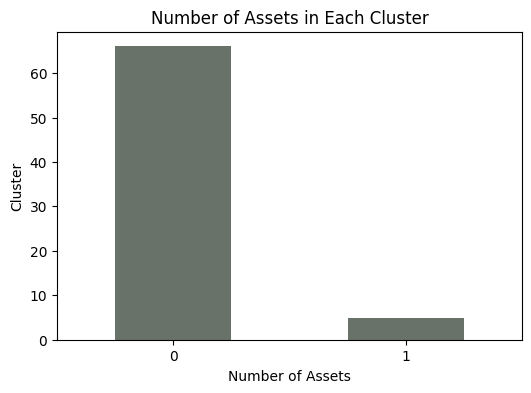

In [58]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = assets_clusters.value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Number of Assets')
plt.ylabel('Cluster')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [60]:
pca_df.to_csv('results/hierarchical_opt/labels_most_common/birch.csv', index = False)